In [85]:
import os
import cv2
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

In [64]:
def load_images_from_folder(folder_path):
    image_data = []  # List to store image data
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            img = cv2.imread(image_path)  # Read the image using OpenCV
            
            if img is not None:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                variance = cv2.Laplacian(gray, cv2.CV_64F).var()
                
                image_info = {
                    'name': filename,  # Store the image filename
                    'image': img,      # Store the loaded image
                    'variance': variance  # Store the calculated variance
                }
                
                image_data.append(image_info)
    return image_data

In [65]:
folder_path = "Downloads/archive (10)/motion_blurred"
images = load_images_from_folder(folder_path)

In [66]:
categories = "blur"  # You can populate this list based on your image categories
variances = [image_info['variance'] for image_info in images]

# Create a dictionary for the DataFrame
data = {
    'Category': categories,
    'Variance': variances
}

In [68]:
df_motion = pd.DataFrame(data)

In [69]:
folder_path = "Downloads/archive (10)/sharp"
images = load_images_from_folder(folder_path)

In [70]:
categories = "sharp"  # You can populate this list based on your image categories
variances = [image_info['variance'] for image_info in images]

# Create a dictionary for the DataFrame
data = {
    'Category': categories,
    'Variance': variances
}

In [71]:
df_sharp = pd.DataFrame(data)

In [72]:
folder_path = "Downloads/archive (10)/defocused_blurred"
images = load_images_from_folder(folder_path)

In [73]:
categories = "blur"  # You can populate this list based on your image categories
variances = [image_info['variance'] for image_info in images]

# Create a dictionary for the DataFrame
data = {
    'Category': categories,
    'Variance': variances
}

In [74]:
df_defocussed = pd.DataFrame(data)

In [75]:
percentiles = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

result_data = []

# Calculate percentiles for each DataFrame and populate the result DataFrame
for percentile in percentiles:
    variance_value = np.percentile(df_defocussed["Variance"], percentile * 100)
    sharpness_value = np.percentile(df_sharp["Variance"], percentile * 100)
    motion_value = np.percentile(df_motion["Variance"], percentile * 100)
    
    result_data.append({
        "Percentile Range": f"{percentile*100}th",
        "df_motion": motion_value,
        "df_defocussed": variance_value,
        "df_sharp": sharpness_value
    })

result_df = pd.DataFrame(result_data)
print(result_df)

   Percentile Range   df_motion  df_defocussed     df_sharp
0             5.0th   11.482836       6.009269    52.453192
1            10.0th   17.294167       9.416464    71.949404
2            20.0th   26.593368      16.344266   115.704969
3            30.0th   33.785206      21.135657   156.027246
4            40.0th   49.559023      26.759629   218.136581
5            50.0th   63.445699      32.139226   261.506980
6            60.0th   82.857104      44.365028   339.417123
7            70.0th  106.146725      60.860307   507.372591
8            80.0th  147.395191      95.664365   651.677632
9            90.0th  275.299966     162.784000  1078.007183
10           95.0th  497.209569     238.494148  1560.368250


In [76]:
combined_df = pd.concat([df_motion, df_defocussed,df_sharp], ignore_index=True)

print(combined_df)

    Category    Variance
0       blur   64.365429
1       blur   78.370947
2       blur   42.468335
3       blur  314.721705
4       blur  417.325428
..       ...         ...
733    sharp  194.254659
734    sharp  139.252947
735    sharp  213.178318
736    sharp  651.677632
737    sharp  225.555985

[738 rows x 2 columns]


In [77]:
# Convert categorical feature to numerical using one-hot encoding
df_encoded = pd.get_dummies(combined_df, columns=['Category'], drop_first=True)

In [78]:
# Split data into features and target
X = df_encoded.drop(columns=['Category_sharp'])  # Dropping one category to avoid multicollinearity
y = df_encoded['Category_sharp']

In [79]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


In [80]:
# Define hyperparameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1,
    'gamma': 0,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
}

In [81]:
# Train the XGBoost model
num_round = 50
model = xgb.train(params, dtrain, num_round)

In [82]:
# Make predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

In [83]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))

Confusion Matrix:
[[89 11]
 [19 29]]


In [84]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.80


In [86]:
# Get predicted probabilities on the test set
y_pred_prob = model.predict(dtest)

In [89]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

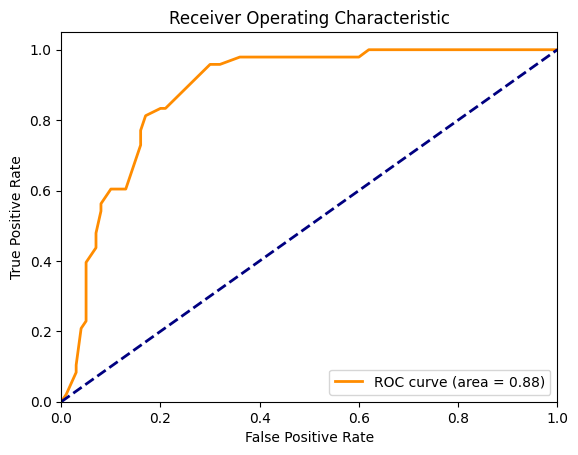

In [90]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()